In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt





C:\Users\saile\AppData\Local\Temp\ipykernel_21576\876829264.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

import time

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, target):
        mse = nn.MSELoss()(pred, target)
        rmse = torch.sqrt(mse)
        return rmse

def train_kinematics_light(train_loader, val_loader, learn_rate, EPOCHS, model, filename, device, w=100):
    model.to(device)
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    running_loss = 0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        for i, (data_acc, data_gyr, data_targets) in enumerate(train_loader):
            optimizer.zero_grad()

            data_acc = data_acc.to(device).float()
            data_gyr = data_gyr.to(device).float()
            data_targets = data_targets.to(device).float().squeeze(-1)

            if isinstance(model, residual_net):
                input_data = torch.cat((data_acc, data_gyr), dim=-1)
                target_output = model(input_data)
            else:
                target_output = model(data_acc, data_gyr)

            loss_1 = criterion(target_output, data_targets)
            loss_1.backward()
            optimizer.step()

            running_loss += loss_1.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data_acc, data_gyr, data_targets in val_loader:
                data_acc = data_acc.to(device).float()
                data_gyr = data_gyr.to(device).float()
                data_targets = data_targets.to(device).float().squeeze(-1)

                if isinstance(model, residual_net):
                    input_data = torch.cat((data_acc, data_gyr), dim=-1)
                    output = model(input_data)
                else:
                    output = model(data_acc, data_gyr)

                val_loss += criterion(output, data_targets).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        epoch_end_time = time.time()
        epoch_training_time = epoch_end_time - epoch_start_time

        print(f"Epoch: {epoch+1}, time: {epoch_training_time:.4f}, Training Loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

        running_loss = 0

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs")
            break

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return model










"""### Lightweight model--Korea Rehabilitation Centre collaboration"""
w=1000
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 16, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(32, 8, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 16, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(32, 8, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2

class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output

class Kinematics_lightweight(nn.Module):
    def __init__(self, input_acc, input_gyr, drop_prob=0.05):
        super(Kinematics_lightweight, self).__init__()

        self.encoder_1_acc = Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr = Encoder_1(input_gyr, drop_prob)

        self.encoder_2_acc = Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr = Encoder_2(input_gyr, drop_prob)

        self.BN_acc = nn.BatchNorm1d(input_acc * 3, affine=False)
        self.BN_gyr = nn.BatchNorm1d(input_gyr * 3, affine=False)

        self.fc = nn.Linear(2 * 2 * 16 + 16, 1)  # Output a single value per sequence

        self.dropout = nn.Dropout(p=0.05)

        self.gate_1 = GatingModule(16)
        self.gate_2 = GatingModule(16)
        self.gate_3 = GatingModule(16)

        self.fc_kd = nn.Linear(2 * 16, 16)

        self.weighted_feat = nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid())

        self.attention = nn.MultiheadAttention(2 * 16, 4, batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(16 * 2, 2 * 16), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2 * 2 * 16 + 16, 2 * 2 * 16 + 16), nn.Sigmoid())

    def forward(self, x_acc, x_gyr):
        batch_size = x_acc.size(0)
        seq_length = x_acc.size(1)
        feature_dim = x_acc.size(2)

        x_acc_1 = x_acc.view(batch_size, -1, feature_dim)
        x_gyr_1 = x_gyr.view(batch_size, -1, feature_dim)

        x_acc_1 = self.BN_acc(x_acc_1)
        x_gyr_1 = self.BN_gyr(x_gyr_1)

        x_acc_2 = x_acc_1.view(batch_size, seq_length, feature_dim)
        x_gyr_2 = x_gyr_1.view(batch_size, seq_length, feature_dim)

        x_acc_1 = self.encoder_1_acc(x_acc_2)
        x_gyr_1 = self.encoder_1_gyr(x_gyr_2)

        x_acc_2 = self.encoder_2_acc(x_acc_2)
        x_gyr_2 = self.encoder_2_gyr(x_gyr_2)

        x_acc = self.gate_1(x_acc_1, x_acc_2)
        x_gyr = self.gate_2(x_gyr_1, x_gyr_2)

        x = torch.cat((x_acc, x_gyr), dim=-1)

        x_kd = self.fc_kd(x)
        out_1, attn_output_weights = self.attention(x, x, x)
        gating_weights = self.gating_net(x)
        out_2 = gating_weights * x

        weights_1 = self.weighted_feat(x[:, :, 0:16])
        weights_2 = self.weighted_feat(x[:, :, 16:2 * 16])

        x_1 = weights_1 * x[:, :, 0:16]
        x_2 = weights_2 * x[:, :, 16:2 * 16]

        out_3 = x_1 + x_2

        out = torch.cat((out_1, out_2, out_3), dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out_f = gating_weights_1 * out

        out = self.fc(out_f)

        return out.squeeze(-1)  # Ensure output is of shape [batch_size, 1]


class residual_net(nn.Module):
    def __init__(self, input_dim, dropout=0.10):
        super(residual_net, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 16, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(32, 8, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten = nn.Flatten()
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

        self.fc = nn.Linear(16, 1)  # Output a single value per sequence

    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1 = self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2 = self.dropout_2(out_2)
        out = self.fc(out_2)
        return out[:, -1, :]  # Return the last output for the sequence




In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os


#load all csvs from the folder and concatenate them into one dataframe by matching the columns
def load_data(path):
    df_list = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            data = pd.read_csv(os.path.join(path, file))
            df_list.append(data)
    df = pd.concat(df_list, ignore_index=True, sort=False)
    return df


# Index 0: pelvis_tilt
# Index 1: pelvis_list
# Index 2: pelvis_rotation
# Index 3: pelvis_tx
# Index 4: pelvis_ty
# Index 5: pelvis_tz
# Index 6: hip_flexion_r
# Index 7: hip_adduction_r
# Index 8: hip_rotation_r
# Index 9: knee_angle_r
# Index 10: knee_angle_r_beta
# Index 11: ankle_angle_r
# Index 12: subtalar_angle_r
# Index 13: mtp_angle_r
# Index 14: hip_flexion_l
# Index 15: hip_adduction_l
# Index 16: hip_rotation_l
# Index 17: knee_angle_l
# Index 18: knee_angle_l_beta
# Index 19: ankle_angle_l
# Index 20: subtalar_angle_l
# Index 21: mtp_angle_l
# Index 22: lumbar_extension
# Index 23: lumbar_bending
# Index 24: lumbar_rotation
# Index 25: arm_flex_r
# Index 26: arm_add_r
# Index 27: arm_rot_r
# Index 28: elbow_flex_r
# Index 29: pro_sup_r
# Index 30: wrist_flex_r
# Index 31: wrist_dev_r
# Index 32: arm_flex_l
# Index 33: arm_add_l
# Index 34: arm_rot_l
# Index 35: elbow_flex_l
# Index 36: pro_sup_l
# Index 37: wrist_flex_l
# Index 38: wrist_dev_l
# Index 39: time
# Index 40: 1
# Index 41: IM EMG1
# Index 42: IM EMG2
# Index 43: IM EMG3
# Index 44: IM EMG4
# Index 45: IM EMG5
# Index 46: IM EMG6
# Index 47: IM EMG7
# Index 48: IM EMG8
# Index 49: ACCX1
# Index 50: ACCY1
# Index 51: ACCZ1
# Index 52: GYROX1
# Index 53: GYROY1
# Index 54: GYROZ1
# Index 55: ACCX2
# Index 56: ACCY2
# Index 57: ACCZ2
# Index 58: GYROX2
# Index 59: GYROY2
# Index 60: GYROZ2
# Index 61: ACCX3
# Index 62: ACCY3
# Index 63: ACCZ3
# Index 64: GYROX3
# Index 65: GYROY3
# Index 66: GYROZ3
# Index 67: ACCX4
# Index 68: ACCY4
# Index 69: ACCZ4
# Index 70: GYROX4
# Index 71: GYROY4
# Index 72: GYROZ4
# Index 73: ACCX5
# Index 74: ACCY5
# Index 75: ACCZ5
# Index 76: GYROX5
# Index 77: GYROY5
# Index 78: GYROZ5
# Index 79: ACCX6
# Index 80: ACCY6
# Index 81: ACCZ6
# Index 82: GYROX6
# Index 83: GYROY6
# Index 84: GYROZ6
# Index 85: ACCX7
# Index 86: ACCY7
# Index 87: ACCZ7
# Index 88: GYROX7
# Index 89: GYROY7
# Index 90: GYROZ7
# Index 91: ACCX8
# Index 92: ACCY8
# Index 93: ACCZ8
# Index 94: GYROX8
# Index 95: GYROY8
# Index 96: GYROZ8


# gait_Net = train_kinematics_light(train_loader, lr,30,model,path+encoder+'_gait_net_kinematics_lightweight.pth')

In [4]:
# data loader will return [batch_size, sequence_length, input_dim] for 3 vector, acc and gyro as well as the target

class KinematicsDataset(Dataset):
    def __init__(self, data_acc, data_gyr, target, w, overlap=200):
        self.data_acc = data_acc
        self.data_gyr = data_gyr
        self.target = target
        self.w = w
        self.overlap = overlap

    def __len__(self):
        return (len(self.data_acc) - self.w) // (self.w - self.overlap) + 1

    def __getitem__(self, idx):
        start = idx * (self.w - self.overlap)
        end = start + self.w
        return (torch.tensor(self.data_acc[start:end]),
                torch.tensor(self.data_gyr[start:end]),
                torch.tensor(self.target[end - 1]))  # Target is the value at the end of the window

    


Total size in bytes: 131144
Total size in kilobytes: 128.07 KB
Total size in bytes: 17348
Total size in kilobytes: 16.94 KB
855
0


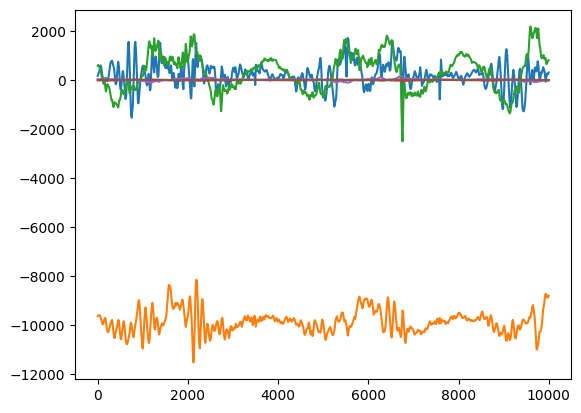

In [5]:
# Instantiate model
model = Kinematics_lightweight(3, 3)

# Calculate the total size of parameters in bytes
total_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
print(f'Total size in bytes: {total_size_bytes}')

# Convert total size in bytes to kilobytes
total_size_kb = total_size_bytes / 1024
print(f'Total size in kilobytes: {total_size_kb:.2f} KB')

# Example alternative model
model = residual_net(6)

# Calculate the total size of parameters in bytes
total_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
print(f'Total size in bytes: {total_size_bytes}')

# Convert total size in bytes to kilobytes
total_size_kb = total_size_bytes / 1024
print(f'Total size in kilobytes: {total_size_kb:.2f} KB')

# Load and clean the combined CSV data
combined_csv = load_data("../../datacollection/vicon/subject_1/combined")

# Check for NaN values
print(combined_csv.isnull().sum().sum())

# Drop NaN values
combined_csv = combined_csv.dropna()

print(combined_csv.isnull().sum().sum())

# Plot ACCX8, ACCY8, ACCZ8, GYROX8, GYROY8, GYROZ8
plt.plot(combined_csv['ACCX8'][:10000])
plt.plot(combined_csv['ACCY8'][:10000])
plt.plot(combined_csv['ACCZ8'][:10000])
plt.plot(combined_csv['GYROX8'][:10000])
plt.plot(combined_csv['GYROY8'][:10000])
plt.plot(combined_csv['GYROZ8'][:10000])
plt.show()

# Get two 3-channel arrays for ACC and GYRO for sensor 2
data_acc = combined_csv[['ACCX2', 'ACCY2', 'ACCZ2']].values
data_gyr = combined_csv[['GYROX2', 'GYROY2', 'GYROZ2']].values

# Normalize the data
scaler_acc = StandardScaler()
scaler_gyr = StandardScaler()

data_acc = scaler_acc.fit_transform(data_acc)
data_gyr = scaler_gyr.fit_transform(data_gyr)

X_train_acc, X_val_acc, X_train_gyr, X_val_gyr, y_train, y_val = train_test_split(
    data_acc, data_gyr, combined_csv[['elbow_flex_r']].values, test_size=0.1, random_state=42)

# Create dataset instances with overlapping windows
train_dataset = KinematicsDataset(X_train_acc, X_train_gyr, y_train, w=1000, overlap=500)
val_dataset = KinematicsDataset(X_val_acc, X_val_gyr, y_val, w=1000, overlap=500)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
#get first batch
data_acc, data_gyr, data_targets = next(iter(train_loader))

#print the shapes of the tensors
print(data_acc.shape)
print(data_gyr.shape)
print(data_targets.shape)

torch.Size([64, 1000, 3])
torch.Size([64, 1000, 3])
torch.Size([64, 1])


In [7]:

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model
gait_Net = train_kinematics_light(train_loader, val_loader, learn_rate=0.001, EPOCHS=1000, model=model, filename='gait_net_kinematics_lightweight.pth', device=device, w=1000)


c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch: 1, time: 0.6870, Training Loss: 75.6366, Validation loss: 80.8935
Epoch: 2, time: 0.4193, Training Loss: 75.2610, Validation loss: 80.2734
Epoch: 3, time: 0.4945, Training Loss: 74.4468, Validation loss: 79.3264
Epoch: 4, time: 0.4794, Training Loss: 73.6035, Validation loss: 78.4641
Epoch: 5, time: 0.4616, Training Loss: 72.6656, Validation loss: 77.7382
Epoch: 6, time: 0.5377, Training Loss: 72.0788, Validation loss: 77.1221
Epoch: 7, time: 0.4255, Training Loss: 71.4195, Validation loss: 76.5718
Epoch: 8, time: 0.4557, Training Loss: 71.1015, Validation loss: 76.0595
Epoch: 9, time: 0.4868, Training Loss: 70.5561, Validation loss: 75.5702
Epoch: 10, time: 0.4253, Training Loss: 69.8709, Validation loss: 75.0950
Epoch: 11, time: 0.4879, Training Loss: 69.3078, Validation loss: 74.6336
Epoch: 12, time: 0.4861, Training Loss: 68.9904, Validation loss: 74.1826
Epoch: 13, time: 0.4656, Training Loss: 68.4363, Validation loss: 73.7385
Epoch: 14, time: 0.4286, Training Loss: 68.1983

In [ ]:
#load in test data
combined_csv_test = load_data("../../datacollection/vicon/subject_2/combined")

# Check for NaN values
print(combined_csv_test.isnull().sum().sum())


# Drop NaN values
combined_csv_test = combined_csv.dropna()

print(combined_csv_test.isnull().sum().sum())

# Plot ACCX8, ACCY8, ACCZ8, GYROX8, GYROY8, GYROZ8
plt.plot(combined_csv_test['ACCX8'][:10000])
plt.plot(combined_csv_test['ACCY8'][:10000])
plt.plot(combined_csv_test['ACCZ8'][:10000])
plt.plot(combined_csv_test['GYROX8'][:10000])
plt.plot(combined_csv_test['GYROY8'][:10000])
plt.plot(combined_csv_test['GYROZ8'][:10000])
plt.show()

# Get two 3-channel arrays for ACC and GYRO for sensor 2
data_acc_test = combined_csv_test[['ACCX2', 'ACCY2', 'ACCZ2']].values
data_gyr_test = combined_csv_test[['GYROX2', 'GYROY2', 'GYROZ2']].values

# Normalize the data
scaler_acc = StandardScaler()
scaler_gyr = StandardScaler()

data_acc_test = scaler_acc.fit_transform(data_acc_test)
data_gyr_test = scaler_gyr.fit_transform(data_gyr_test)


# Create dataset instances with overlapping windows for test data
test_dataset = KinematicsDataset(data_acc_test, data_gyr_test, combined_csv_test[['elbow_flex_r']].values, w=1000, overlap=500)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the trained model
model = Kinematics_lightweight(3, 3)
model.load_state_dict(torch.load('gait_net_kinematics_lightweight.pth'))
model.eval()
model.to(device)

# Evaluate the model on the test set
test_loss = 0
all_predictions = []
all_targets = []

criterion = RMSELoss()

with torch.no_grad():
    for data_acc, data_gyr, data_targets in test_loader:
        data_acc = data_acc.to(device).float()
        data_gyr = data_gyr.to(device).float()
        data_targets = data_targets.to(device).float().squeeze(-1)

        output = model(data_acc, data_gyr)
        loss = criterion(output, data_targets)
        test_loss += loss.item()

        all_predictions.append(output.cpu().numpy())
        all_targets.append(data_targets.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Combine all predictions and targets
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(all_targets, label='True Values')
plt.plot(all_predictions, label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Elbow Flexion (r)')
plt.legend()
plt.title('Predictions vs True Values')
plt.show()


728
